# Task 3

## Reading the secrets and importing the requirements

In [2]:
from secrets_import import * # check the secrets_import file for details

In [3]:
from config_setup_helper import * # check the config_setup file for details

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/shubhamdarekar/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /home/shubhamdarekar/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /home/shubhamdarekar/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [4]:
import time
from datetime import datetime,UTC
from bs4 import BeautifulSoup
import re
import pytesseract
from PIL import Image
import requests
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

from gensim.models.doc2vec import Doc2Vec, TaggedDocument, Word2Vec
import pymysql
import numpy as np

## Scraping and cleaning helpers

In [5]:
# Load stopwords for keyword extraction
stop_words = set(stopwords.words('english'))

def clean_text(text):
    """Remove HTML, special characters, ads, and extra spaces."""
    if not text:
        return ""  # Handle empty text cases

    # Remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()

    # Remove special characters, links, and promoted messages
    text = re.sub(r'http\S+|www\S+', '', text)  # Remove URLs
    text = re.sub(r'\W+', ' ', text)  # Remove special characters
    text = text.lower().strip()  # Convert to lowercase

    # Mask usernames
    text = re.sub(r'u/[A-Za-z0-9_-]+', '[USERNAME]', text)
    
    # remove stopwords
    words = word_tokenize(text)
    filtered_words = [word for word in words if word not in stop_words]
    text = ' '.join(filtered_words)

    return text

def extract_keywords(text):
    """Extract important keywords from the post content."""
    words = word_tokenize(text)
    keywords = [word for word in words if word.isalnum() and word not in stop_words]
    return ', '.join(set(keywords))  # Convert list to string for storage

def extract_text_from_images(image_url):
    """Extract text from images using OCR (Pytesseract)."""
    try:
        # Download the image (placeholder, needs proper downloading logic)
        requests.get(image_url, stream=True).raw
        image = Image.open(requests.get(image_url, stream=True).raw)  # This assumes the image is already downloaded
        text = pytesseract.image_to_string(image)
        return clean_text(text)
    except Exception as e:
        print(f"Could not process image {image_url}: {e}")
        return ""


## Code to pull and save the posts in DB

In [6]:
def fetch_and_store_reddit_posts(subreddit_name, n_posts):
    """Fetch, preprocess, and store Reddit posts while handling large requests."""
    setup_database()

    subreddit = reddit.subreddit(subreddit_name)
    batch_size = 1000  # Max Reddit API limit per request
    fetched_posts = 0
    conn = pymysql.connect(host=MYSQL_HOST, user=MYSQL_USER, password=MYSQL_PASSWORD, database = MYSQL_DB)
    cursor = conn.cursor()

    while fetched_posts < n_posts:
        limit = min(batch_size, n_posts - fetched_posts)

        print(f"Fetching {limit} posts...")

        try:
            for post in subreddit.hot(limit=limit):
                title = post.title
                content = clean_text(post.selftext) 
                
                timestamp = datetime.fromtimestamp(post.created_utc, UTC)
                
                image_text = ""
                if hasattr(post, "preview") and "images" in post.preview:
                    image_url = post.preview["images"][0]["source"]["url"]
                    image_text = extract_text_from_images(image_url)
                    
                    
                if not content and not image_text:
                    continue
                
                keywords = extract_keywords(title+" "+content+" "+image_text)  # Extract keywords

                # Store in MySQL
                sql = "INSERT INTO posts (title, content, timestamp, subreddit, keywords, image_text) VALUES (%s, %s, %s, %s, %s, %s)"
                cursor.execute(sql, (title, content, timestamp, subreddit_name, keywords, image_text))

                fetched_posts += 1
                if fetched_posts >= n_posts:
                    break  # Stop when we reach desired count

            conn.commit()
            print(f"Stored {fetched_posts} posts so far.")

        except Exception as e:
            print(f"Error fetching posts: {e}")
            time.sleep(5)  # Retry after a short delay

        time.sleep(2)  # Avoid rate limits

    print(f"Successfully stored {fetched_posts} posts.")
    conn.close()

### Calling the function (run all above cells first)

In [7]:
if __name__ == "__main__":
    fetch_and_store_reddit_posts("askscience", 20)

Database and table setup complete.
Fetching 20 posts...
Stored 16 posts so far.
Fetching 4 posts...
Stored 19 posts so far.
Fetching 1 posts...
Stored 20 posts so far.
Successfully stored 20 posts.


# Task 4

### Part A: Generating Embeddings

#### Using both doc2vec and word2 vec to generate 2 seperate embeddings

In [ ]:
def get_all_posts():
    conn = pymysql.connect(host=MYSQL_HOST, user=MYSQL_USER, password=MYSQL_PASSWORD, db=MYSQL_DB)
    cursor = conn.cursor()
    cursor.execute("SELECT id, title, content, image_text FROM posts")
    posts =  cursor.fetchall()
    conn.close()
    return posts



def doc2Vec_embeddings(posts):
    tagged_data = [TaggedDocument(words=word_tokenize(clean_text(" ".join([str(x).lower() for x in row[1:]]))), tags=[str(row[0])]) for row in posts]
    model_doc = Doc2Vec(vector_size=20, window=2, min_count=1, workers=4, epochs=20)
    model_doc.build_vocab(tagged_data)

    model_doc.train(tagged_data, total_examples=model_doc.corpus_count, epochs=model_doc.epochs)
    vectors_doc = []
    for row in posts:
        doc_id = str(row[0])
        if doc_id in model_doc.dv:
            vectors_doc.append(model_doc.dv[doc_id])
        else:
            vectors_doc.append(np.zeros(model_doc.vector_size))

    vectors_doc = np.array(vectors_doc)
    
    return vectors_doc,model_doc

def word2Vec_embeddings(posts):
    tokenized_posts = [word_tokenize(clean_text(" ".join([str(x).lower() for x in row[1:]]))) for row in posts]
    model = Word2Vec(sentences=tokenized_posts, vector_size=100, window=5, min_count=1, workers=4, epochs=20)



    vectors = []
    for row in posts:
        words = word_tokenize(row[1].lower())
        word_vectors = [model.wv[word] for word in words if word in model.wv]
        if word_vectors:
            vectors.append(np.mean(word_vectors, axis=0))
        else:
            vectors.append(np.zeros(model.vector_size))

    vectors = np.array(vectors)
    
    return vectors,model


posts = get_all_posts()
# print(len(posts))

vectors_doc,model_doc = doc2Vec_embeddings(posts)
print("Doc2Vec embeddings generated.")

vectors_word,model_word = word2Vec_embeddings(posts)
print("Word2Vec embeddings generated.")


np.save("doc2vec_embeddings.npy", vectors_doc)
np.save("word2vec_embeddings.npy", vectors_word)


20
Doc2Vec embeddings generated.
Word2Vec embeddings generated.


### Part B: KMeans to cluster the data

In [9]:
from sklearn.cluster import KMeans

def kmeans_clustering(vectors, num_clusters,posts):
    kmeans = KMeans(n_clusters=num_clusters, random_state=42)
    clusters = kmeans.fit_predict(vectors)
    
    labeled_cluster = list(zip([row[0] for row in posts], clusters))
    
    return kmeans,labeled_cluster,clusters

In [10]:
kmeans_doc,labeled_cluster_doc, cluster_doc = kmeans_clustering(vectors_doc, 5,posts)
print("Doc2Vec clustering done.")

Doc2Vec clustering done.


In [11]:
kmeans_word,labeled_cluster_word,cluster_word = kmeans_clustering(vectors_word, 5,posts)
print("Word2Vec clustering done.")

Word2Vec clustering done.


In [12]:
# Store cluster labels in MySQL
def store_cluster_labels(labeled_cluster_doc,labeled_cluster_word):
    conn = pymysql.connect(host=MYSQL_HOST, user=MYSQL_USER, password=MYSQL_PASSWORD, db=MYSQL_DB)
    cursor = conn.cursor()
    
    for i in range(len(labeled_cluster_doc)):
        post_id, cluster_id_doc = labeled_cluster_doc[i]
        post_id_word, cluster_id_word = labeled_cluster_word[i]
        
        if post_id != post_id_word:
            raise ValueError("Post IDs do not match between the two clustering results.")
        
        cursor.execute("UPDATE posts SET cluster_id_doc=%s, cluster_id=%s WHERE id=%s", (cluster_id_doc, cluster_id_word, post_id))

    conn.commit()
    conn.close()
    
store_cluster_labels(labeled_cluster_doc,labeled_cluster_word)

In [13]:
from collections import Counter

def get_all_posts():
    conn = pymysql.connect(host=MYSQL_HOST, user=MYSQL_USER, password=MYSQL_PASSWORD, db=MYSQL_DB)
    cursor = conn.cursor()
    cursor.execute("SELECT id, title, content, image_text,cluster_id,cluster_id_doc FROM posts")
    posts =  cursor.fetchall()
    conn.close()
    return posts


def organize_by_clusters(post):
    cluster_dict_word = {}
    cluster_dict_doc = {}
    for row in posts:
        cluster_id_word = row[-2]
        cluster_id_doc = row[-1]
        
        if cluster_id_word not in cluster_dict_word:
            cluster_dict_word[cluster_id_word] = []
        cluster_dict_word[cluster_id_word].append(row)
        
        if cluster_id_doc not in cluster_dict_doc:
            cluster_dict_doc[cluster_id_doc] = []
        cluster_dict_doc[cluster_id_doc].append(row)
    return cluster_dict_doc,cluster_dict_word

posts= get_all_posts()
cluster_dict_doc,cluster_dict_word = organize_by_clusters(posts)



def extract_keywords(texts):
    
    all_words = " ".join(texts)
    all_words = clean_text(all_words).split()
    word_counts = Counter(all_words)
    return ", ".join([word for word, _ in word_counts.most_common(10)])  # Top 5 keywords ## TODO: Change this strategy, remove stopword

cluster_keywords_word = {cluster_id: extract_keywords([row[1] +" "+ row[2] +" "+ row[3] for row in contents]) for cluster_id, contents in cluster_dict_word.items()}
cluster_keywords_doc = {cluster_id: extract_keywords([row[1] +" "+ row[2] +" "+ row[3] for row in contents]) for cluster_id, contents in cluster_dict_doc.items()}



In [14]:
import pprint
print("Keywords by cluster using Word to vec")
pprint.pprint(cluster_keywords_word)
print("Keywords by cluster using Doc to vec")
pprint.pprint(cluster_keywords_doc)

Keywords by cluster using Word to vec
{0: 'amputated, happens, limb, gets, could, understand, people, got, leg, '
    'curious',
 1: 'get, rabies, oldest, could, species, permafrost, around, exposure, '
    'vaccines, years',
 2: 'field, panel, panelist, comments, askscience, application, please, post, '
    'one, expertise',
 3: 'would, core, ask, earth, understand, alleles, gene, know, life, like',
 4: 'cookware, would, water, small, pot, also, energy, steam, dinosaurs, '
    'survived'}
Keywords by cluster using Doc to vec
{0: 'life, earth, would, evolve, breathe, oxygen, air, nitrogen, core, metal',
 1: 'field, panel, panelist, comments, askscience, application, please, post, '
    'one, expertise',
 2: 'would, understand, alleles, gene, human, genes, foxp2, nf, 1, language',
 3: 'core, inner, cookware, get, rabies, know, could, water, also, small',
 4: 'ask, question, questions, anything, askscience, post, please, wednesday, '
    'r, answer'}


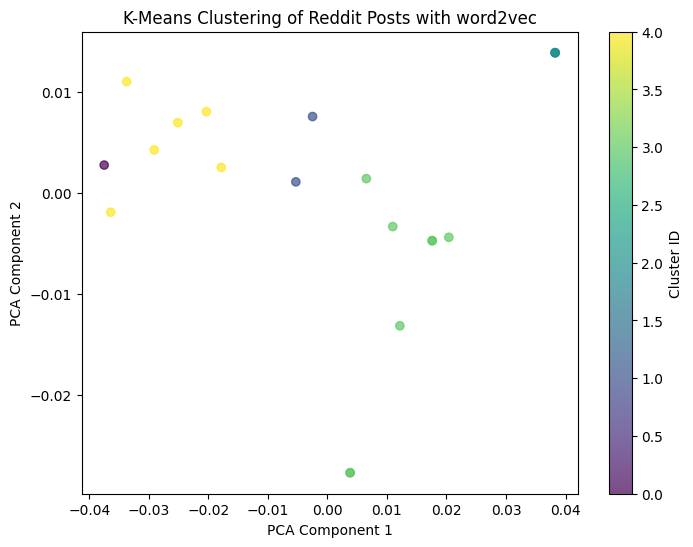

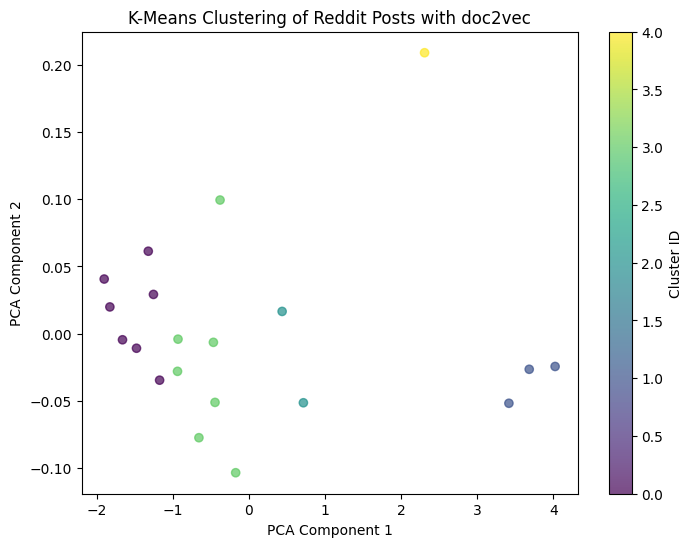

In [15]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors_word)

# Scatter plot of clusters
plt.figure(figsize=(8,6))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=cluster_word, cmap='viridis', alpha=0.7)
plt.title("K-Means Clustering of Reddit Posts with word2vec")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster ID")
plt.show()


pca = PCA(n_components=2)
reduced_vectors = pca.fit_transform(vectors_doc)

# Scatter plot of clusters
plt.figure(figsize=(8,6))
plt.scatter(reduced_vectors[:, 0], reduced_vectors[:, 1], c=cluster_doc, cmap='viridis', alpha=0.7)
plt.title("K-Means Clustering of Reddit Posts with doc2vec")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.colorbar(label="Cluster ID")
plt.show()


In [16]:
#  code to predict cluster of a new text with both methods
def predict_cluster(text, model_doc, model_word, kmeans_doc, kmeans_word):
    text = clean_text(text)
    
    # Infer vector using Doc2Vec model
    vector_doc = model_doc.infer_vector(word_tokenize(text))
    
    # Calculate mean vector using Word2Vec model
    word_vectors = [model_word.wv[word] for word in word_tokenize(text) if word in model_word.wv]
    if word_vectors:
        vector_word = np.mean(word_vectors, axis=0)
    else:
        vector_word = np.zeros(model_word.vector_size)
    
    # Ensure vectors are in the correct format and data type
    vector_doc = np.array(vector_doc, dtype=np.float32)
    vector_word = np.array(vector_word, dtype=np.float32)
    
    # Predict clusters
    cluster_doc = kmeans_doc.predict(vector_doc.reshape(1, -1))[0]
    cluster_word = kmeans_word.predict(vector_word.reshape(1, -1))[0]
    
    return cluster_doc, cluster_word

if __name__ == "__main__":

    text = "What is the difference between a virus and a bacteria?"
    print("\n")
    print(text)
    cluster_doc, cluster_word = predict_cluster(text, model_doc, model_word, kmeans_doc, kmeans_word)
    print(f"Predicted cluster (doc2vec): {cluster_doc}")
    print(f"Predicted cluster (word2vec): {cluster_word}")

    text2 = "Dinasours are very old"
    print("\n")

    print(text2)
    cluster_doc, cluster_word = predict_cluster(text2, model_doc, model_word, kmeans_doc, kmeans_word)
    print(f"Predicted cluster (doc2vec): {cluster_doc}")
    print(f"Predicted cluster (word2vec): {cluster_word}")



What is the difference between a virus and a bacteria?
Predicted cluster (doc2vec): 0
Predicted cluster (word2vec): 4


Dinasours are very old
Predicted cluster (doc2vec): 0
Predicted cluster (word2vec): 4


In [17]:
def predict_similar_posts(text, model_doc, model_word, kmeans_doc, kmeans_word, posts):
    cluster_doc, cluster_word = predict_cluster(text, model_doc, model_word, kmeans_doc, kmeans_word)
    
    similar_posts_doc = [post for post in posts if post[-1] == cluster_doc]
    similar_posts_word = [post for post in posts if post[-2] == cluster_word]
    
    return similar_posts_doc, similar_posts_word